# MNIST-Classification

David S. White

2020-05-18

**Goal:** Classify handwritten digits of the MNIST dataset

Adapted from Chapter 3 of "Hands on Machine Learning w/ Scikit-Learn and TensorFlow by Aurelien Geron" (O'Reilly)

### Libraries 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# seaborn style 
sns.set()

### Load MNIST dataset from sklearn
* This dataset contains 7000 images each composed of 784 features (28x28 pixels)
* Digits range from 0 to 9

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
X, y = mnist["data"], mnist["target"]

In [3]:
print('Shape of X: ', np.shape(X))
print('Shape of y: ', np.shape(y))

Shape of X:  (70000, 784)
Shape of y:  (70000,)


### Split Data into Training & Test Sets
* shuffle data  
* split 80/20 train/test

In [4]:
# Shuffle data with permutation
from sklearn.utils import check_random_state
random_state = check_random_state(42)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [5]:
# split into test and train sets
from sklearn.model_selection import train_test_split

test_percent = 0.2
test_set_size = int(test_percent*X.shape[0])
num_test = int(test_percent*X.shape[0])
num_train = int((1-test_percent)*X.shape[0])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=num_train, test_size=num_test)

In [6]:
# standardize the training data 
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float64))

### Plot a random image

In [7]:
def plotImage(X, rand_idx=[]):
    if not rand_idx:
        import random 
        rand_idx = random.randint(0,X.shape[0])
    rand_img = X[rand_idx]
    rand_img_show = rand_img.reshape(28,28)
    plt.imshow(rand_img_show, cmap=plt.cm.binary, interpolation="nearest")
    plt.axis('off')
    plt.show()
    
    return rand_idx

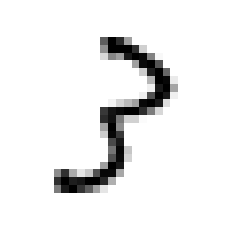

True Value: 3


In [8]:
rand_idx = plotImage(X, rand_idx=10)
rand_int = y[rand_idx]
print('True Value:', rand_int)

## Train a Binary Classifier: 
### Method 1: Stochastic Gradient Descent
Should be able to train the classifier quickly and is a good place to start.

In [9]:
y_train_rnd = (y_train == rand_int)
y_test_rnd = (y_test == rand_int)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_rnd)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

check result on a random image previously shown 

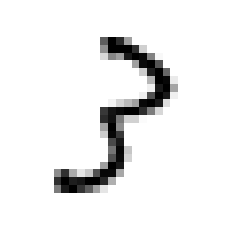

True Value: 3
Value ==  3 : True


In [11]:
rand_int_pred = sgd_clf.predict([X[rand_idx]])
plotImage(X, rand_idx)
print('True Value:', rand_int)
print('Value == ', rand_int,':', rand_int_pred[0])

### Evaluate classifer performance with confusion matrix
<br>
<br>
$$ Precision = \frac{TP}{TP + FP}$$
<br>
<br>
$$ Recall = \frac{TP}{TP + FN}$$
<br>
<br>
$$ F1 = \frac {2} {\frac{1}{precision} + \frac{1}{recall}} = 2\times \frac {precision  \times  recall}{precision +recall} = \frac{TP}{TP + {\frac{FN + FP} {2}}}$$

where: 
* TP = True Positive 
* FP = False Positive
* FN = False Negative 

F1 is is the harmonic mean of precision and recall 

In [12]:
from sklearn.model_selection import cross_val_predict 
y_train_pred_sgd = cross_val_predict(sgd_clf, X_train, y_train_rnd, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_rnd, y_train_pred_sgd)

array([[49793,   483],
       [ 1001,  4723]])

In [14]:
def computeScore(true_values, predicted_values):
    from sklearn.metrics import precision_score, recall_score, f1_score
    p = precision_score(true_values, predicted_values)
    r = recall_score(true_values, predicted_values)
    f1 = f1_score(true_values, predicted_values)
    print('Precision:', "%.3f" %p)
    print('Recall:', "%.3f" %r)
    print('F1:', "%.3f" %f1)

In [15]:
computeScore(y_train_rnd, y_train_pred_sgd)

Precision: 0.907
Recall: 0.825
F1: 0.864


## ROC Curve
visualize false postive rate vs true postive rate

In [16]:
y_scores_sgd = cross_val_predict(sgd_clf, X_train, y_train_rnd, cv=3, method='decision_function')

In [17]:
from sklearn.metrics import roc_curve 
fpr_sgd, tpr_sgd, threshold_sgd = roc_curve(y_train_rnd, y_scores_sgd) 

In [18]:
def plotROCCurve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Postive Rate')

Compute area under roc curve (AUC) as measure of classifier performance

### Try Random Forest Classification

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_rnd,cv=3, method='predict_proba')

In [20]:
y_scores_forest = y_prob_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_rnd, y_scores_forest) 

Compare results

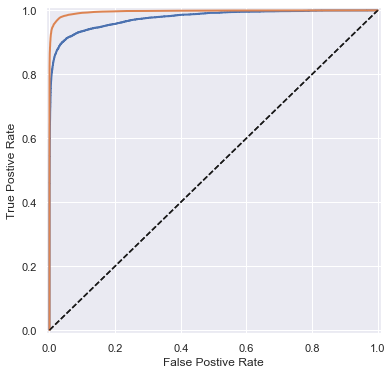

In [21]:
plt.figure(figsize=(6, 6))
plotROCCurve(fpr_sgd, tpr_sgd, 'SGD')
plotROCCurve(fpr_forest, tpr_forest, 'Random Forest')
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_sgd = roc_auc_score(y_train_rnd, y_scores_sgd)
roc_auc_forest = roc_auc_score(y_train_rnd, y_scores_forest)
print('Area Under ROC Curve SGD: ', '%0.3f' % roc_auc_sgd)
print('Area Under ROC Curve RFC: ', '%0.3f' % roc_auc_forest)

Area Under ROC Curve SGD:  0.976
Area Under ROC Curve RFC:  0.996


In [23]:
y_train_pred_forest = y_train_rnd
for i in range(0,len(y_train_pred_forest)):
    y_train_pred_forest[i] = bool(y_prob_forest[i,0] < y_prob_forest[i, 1])

In [24]:
computeScore(y_train_rnd, y_train_pred_forest)

Precision: 1.000
Recall: 1.000
F1: 1.000


random forest classifer is perofrming better than stochastic gradient descent 

## Multiclass Classification using RandomForestClassifier 